In [ ]:
# install the packages :
!pip install torchmetrics
!pip install torch-fidelity
!pip install torchmetrics[image]

In [ ]:
# imports : 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import torch.nn.functional as F
from torchvision.models import inception_v3
import numpy as np
import scipy
from scipy.linalg import sqrtm

# ***Image generation of FASHION-MNIST via β-VAE***

Loading FAHSION MNIST dataset

In [ ]:
# Hyper parameters : 
Hypers = {
    "train_batch_size" : 64,
    "test_batch_size" : 128,
    "device" : torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "latent_dim" : 10,
    "beta" : 2.0,
    "lr" : 0.002,
    "num_epochs" : 25
}

In [ ]:
# load Fashion mnist dataset : 
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=False)
train_loader = DataLoader(train_dataset, batch_size=Hypers['train_batch_size'], shuffle=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=False)
test_loader = DataLoader(test_dataset, batch_size=Hypers['test_batch_size'], shuffle=False)

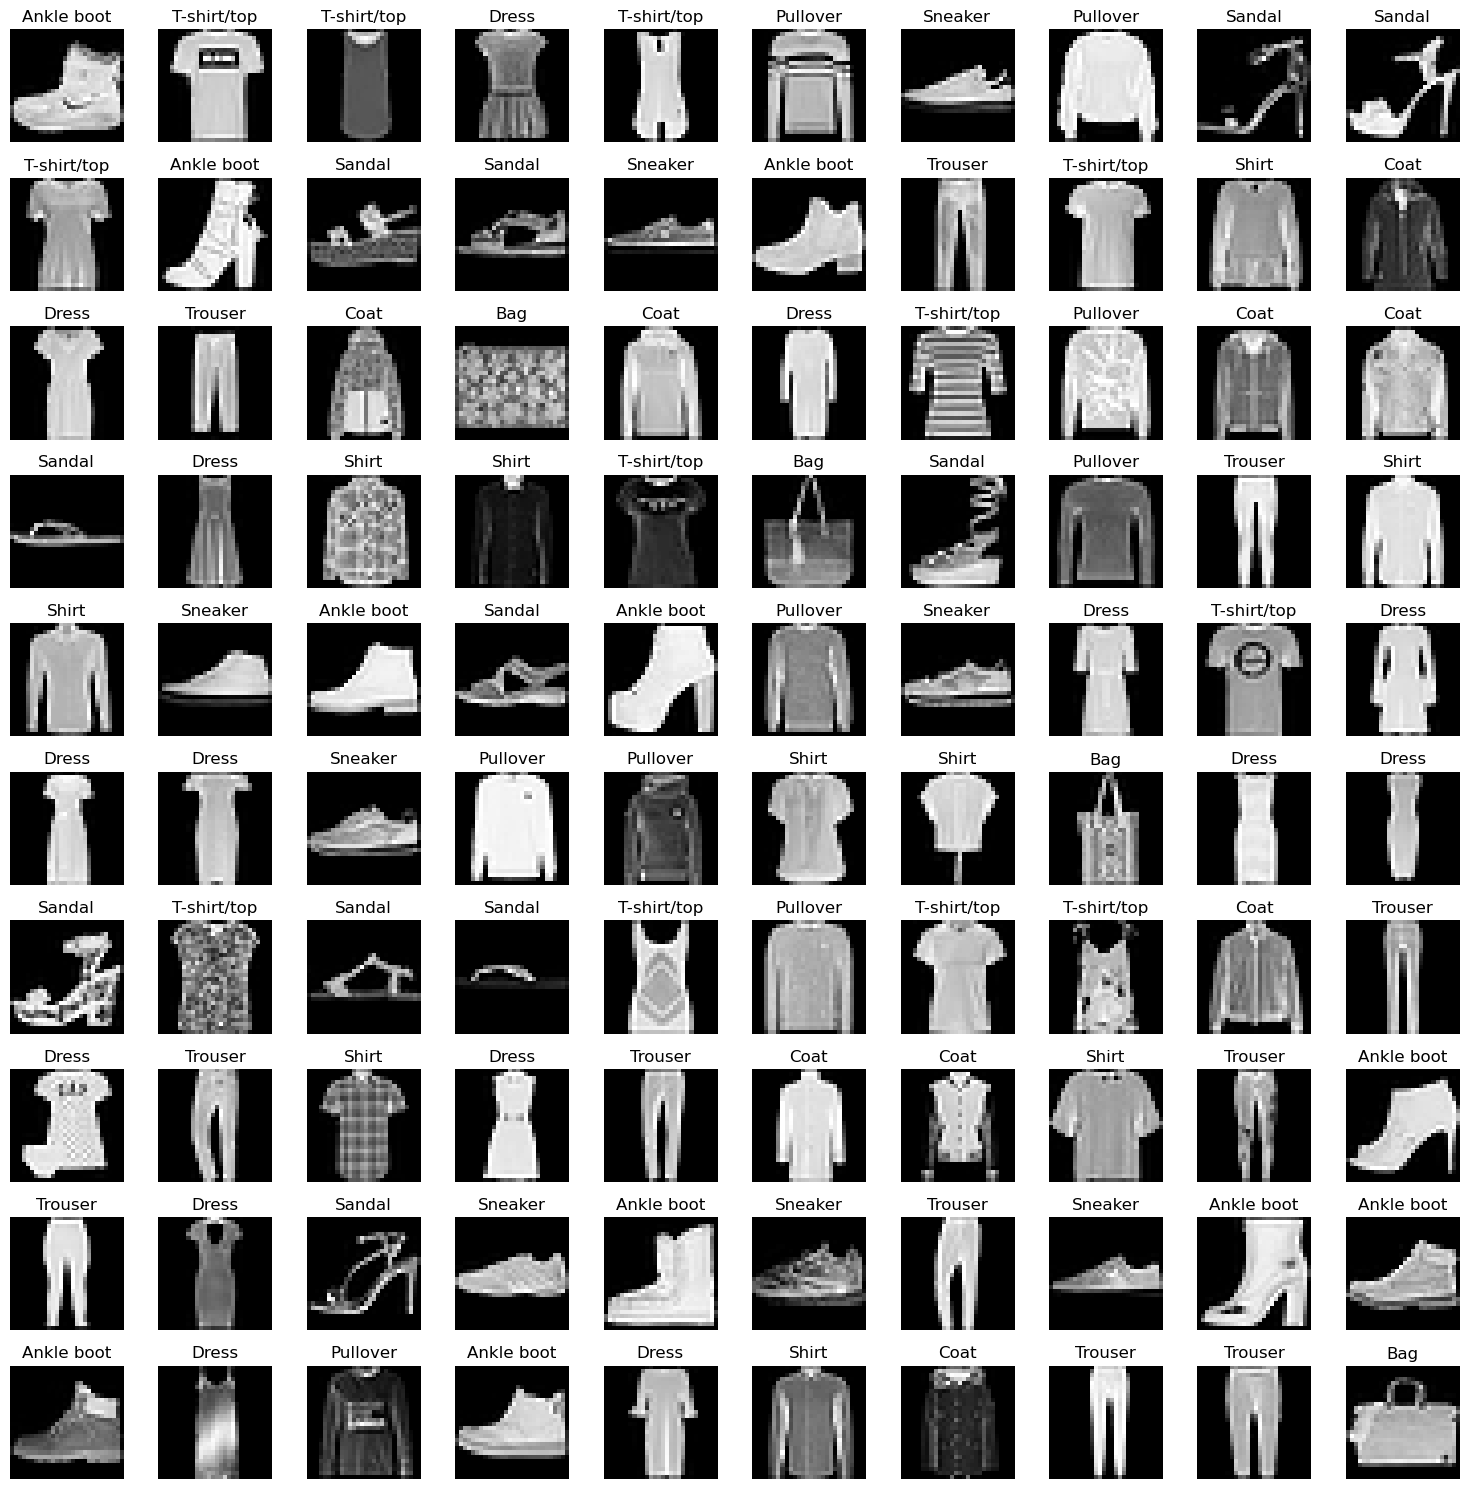

In [ ]:
# visualize some samples from mnist dataset : 
class_names = train_dataset.classes

def visualize_dataset(dataset, n_images=100):
    fig, axes = plt.subplots(int(np.sqrt(n_images)), int(np.sqrt(n_images)), figsize=(15, 15))
    axes = axes.flatten()

    for i in range(n_images):
        img, label = dataset[i]
        img = img

        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(class_names[label])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_dataset(train_dataset)

In [ ]:
# see the shape of pictures : 
print(train_dataset[0][0].shape)

torch.Size([1, 28, 28])


#**Theory**

**Encoder and decoder of VAE are decoded as follows.**
- Encoder (Gaussian distribution)：$$q_{\phi}({\bf z}|{\bf x}) = {\mathcal N}({\bf z}| \mu,\sigma^2{\bf I}), 　s.t.　\mu=g^{\mu}_{\phi}({\bf x}), \sigma=g^{\sigma}_{\phi}({\bf x}). $$
- Decoder (Bernoulli distribution)：$$p_{\theta}({\bf x}|{\bf z}) = Ber({\bf x}| \lambda), 　s.t.　\lambda=f_{\theta}({\bf z}).$$
<br>

**ELBO (Evidence Lower BOund) is represented like below.**  The first and the second term are corresponding to (minus) reconstruction loss and KL divergence, respectively. For the implementation of β-VAE, the coefficient β(>1) in the regularisation term of the objective function is needed in order to make the model more disentangled.


$$
 {\mathcal L}({\bf x};{\bf \theta},{\bf \phi}) = \mathbb{E}_{q_{\phi}({\bf z}|{\bf x})}[\log p_\theta({\bf x}|{\bf z})] -\beta D_{KL}[q_{\phi}({\bf z}|{\bf x})||p_{\theta}({\bf z})]
 $$  

#**MODEL**

In [ ]:
# encoder class : 
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 3 * 3, 128)
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

    def forward(self, x):
        x = self.layers(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [ ]:
# decoder class : 
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 32 * 3 * 3),
            nn.ReLU() 
        )

        self.conv_transpose = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0, output_padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.decoder(x)
        x = x.view(-1, 32, 3, 3)
        x = self.conv_transpose(x)
        return x

In [ ]:
# beta vae classs : 
class BetaVAE(nn.Module):
    def __init__(self, latent_dim=10, beta=1.0):
        super(BetaVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

In [ ]:
# loss function of beta vae : 
def vae_loss(recon_x, x, mu, log_var, beta=1.0):
    criterion = nn.MSELoss(reduction='sum')
    MSE = criterion(recon_x, x)
    KLD = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
    return MSE + beta * KLD

# **TRAINING**

In [ ]:
# train one epoch : 
def train(model, data_loader, device, beta, optimizer):
    model.train()
    train_loss = 0
    progress_bar = tqdm(data_loader, desc="Training")
    for x, _ in progress_bar:
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, log_var = model(x)
        loss = vae_loss(recon_x, x, mu, log_var, beta)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        progress_bar.set_postfix({'loss': train_loss / len(data_loader)})
    average_train_loss = train_loss / len(data_loader.dataset)
    return average_train_loss

In [ ]:
# evaluate one epoch : 
def evaluate(model, data_loader, device, beta):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Evaluating")
        for x, _ in progress_bar:
            x = x.to(device)
            recon_x, mu, log_var = model(x)
            loss = vae_loss(recon_x, x, mu, log_var, beta)
            test_loss += loss.item()
            progress_bar.set_postfix({'loss': test_loss / len(data_loader)})
    average_loss = test_loss / len(data_loader.dataset)
    return average_loss

In [ ]:
# train a beta vae model : 
vae = BetaVAE(Hypers['latent_dim']).to(Hypers['device'])
optimizer = optim.Adam(vae.parameters(), lr=Hypers['lr'])

train_losses, val_losses = [], []

for epoch in range(Hypers['num_epochs']):
  print(f"Epoch {epoch+1}/{Hypers['num_epochs']}")
  train_loss = train(vae, train_loader, Hypers['device'], Hypers['beta'], optimizer)
  val_loss = evaluate(vae, test_loader, Hypers['device'], Hypers['beta'])
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  print("-" * 100)
  if val_loss == min(val_losses):
    torch.save(vae.state_dict(), "vae.pth")

Epoch 1/25


Evaluating: 100%|██████████| 79/79 [00:00<00:00, 86.55it/s, loss=1.8e+3] 


----------------------------------------------------------------------------------------------------
Epoch 2/25


Evaluating: 100%|██████████| 79/79 [00:00<00:00, 92.64it/s, loss=1.63e+3]


----------------------------------------------------------------------------------------------------
Epoch 3/25


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 68.36it/s, loss=1.54e+3]


----------------------------------------------------------------------------------------------------
Epoch 4/25


Evaluating: 100%|██████████| 79/79 [00:00<00:00, 79.89it/s, loss=1.52e+3]


----------------------------------------------------------------------------------------------------
Epoch 5/25


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 74.99it/s, loss=1.48e+3]


----------------------------------------------------------------------------------------------------
Epoch 6/25


Evaluating: 100%|██████████| 79/79 [00:00<00:00, 93.87it/s, loss=1.48e+3]


----------------------------------------------------------------------------------------------------
Epoch 7/25


Evaluating: 100%|██████████| 79/79 [00:00<00:00, 88.27it/s, loss=1.48e+3]


----------------------------------------------------------------------------------------------------
Epoch 8/25


Evaluating: 100%|██████████| 79/79 [00:00<00:00, 88.97it/s, loss=1.45e+3]


----------------------------------------------------------------------------------------------------
Epoch 9/25


Evaluating: 100%|██████████| 79/79 [00:00<00:00, 88.39it/s, loss=1.43e+3]


----------------------------------------------------------------------------------------------------
Epoch 10/25


Evaluating: 100%|██████████| 79/79 [00:00<00:00, 92.23it/s, loss=1.42e+3]


----------------------------------------------------------------------------------------------------
Epoch 11/25


Evaluating: 100%|██████████| 79/79 [00:00<00:00, 97.34it/s, loss=1.41e+3] 


----------------------------------------------------------------------------------------------------
Epoch 12/25


Evaluating: 100%|██████████| 79/79 [00:00<00:00, 81.44it/s, loss=1.39e+3]


----------------------------------------------------------------------------------------------------
Epoch 13/25


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 72.84it/s, loss=1.39e+3]


----------------------------------------------------------------------------------------------------
Epoch 14/25


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 75.63it/s, loss=1.4e+3] 


----------------------------------------------------------------------------------------------------
Epoch 15/25


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 75.34it/s, loss=1.44e+3]


----------------------------------------------------------------------------------------------------
Epoch 16/25


Evaluating: 100%|██████████| 79/79 [00:00<00:00, 80.89it/s, loss=1.4e+3] 


----------------------------------------------------------------------------------------------------
Epoch 17/25


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 76.58it/s, loss=1.39e+3]


----------------------------------------------------------------------------------------------------
Epoch 18/25


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 77.31it/s, loss=1.4e+3] 


----------------------------------------------------------------------------------------------------
Epoch 19/25


Evaluating: 100%|██████████| 79/79 [00:00<00:00, 79.56it/s, loss=1.38e+3]


----------------------------------------------------------------------------------------------------
Epoch 20/25


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 70.80it/s, loss=1.37e+3]


----------------------------------------------------------------------------------------------------
Epoch 21/25


Evaluating: 100%|██████████| 79/79 [00:00<00:00, 84.89it/s, loss=1.37e+3]


----------------------------------------------------------------------------------------------------
Epoch 22/25


Evaluating: 100%|██████████| 79/79 [00:00<00:00, 87.49it/s, loss=1.38e+3]


----------------------------------------------------------------------------------------------------
Epoch 23/25


Evaluating: 100%|██████████| 79/79 [00:00<00:00, 90.16it/s, loss=1.37e+3]


----------------------------------------------------------------------------------------------------
Epoch 24/25


Evaluating: 100%|██████████| 79/79 [00:00<00:00, 90.06it/s, loss=1.35e+3]


----------------------------------------------------------------------------------------------------
Epoch 25/25


Evaluating: 100%|██████████| 79/79 [00:00<00:00, 91.84it/s, loss=1.34e+3]

----------------------------------------------------------------------------------------------------


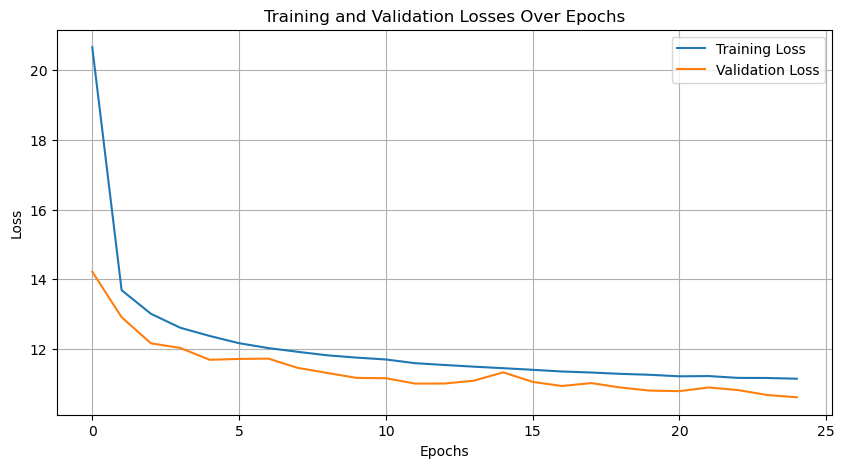

In [ ]:
# plot the train and validation losses : 
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_losses(train_losses, val_losses)

In [ ]:
# load saved model : 
vae = BetaVAE().to(Hypers['device'])

vae.load_state_dict(torch.load("vae.pth"))
vae.eval()
print("Model loaded!")

**Visualization of reconstructed image**

Original image

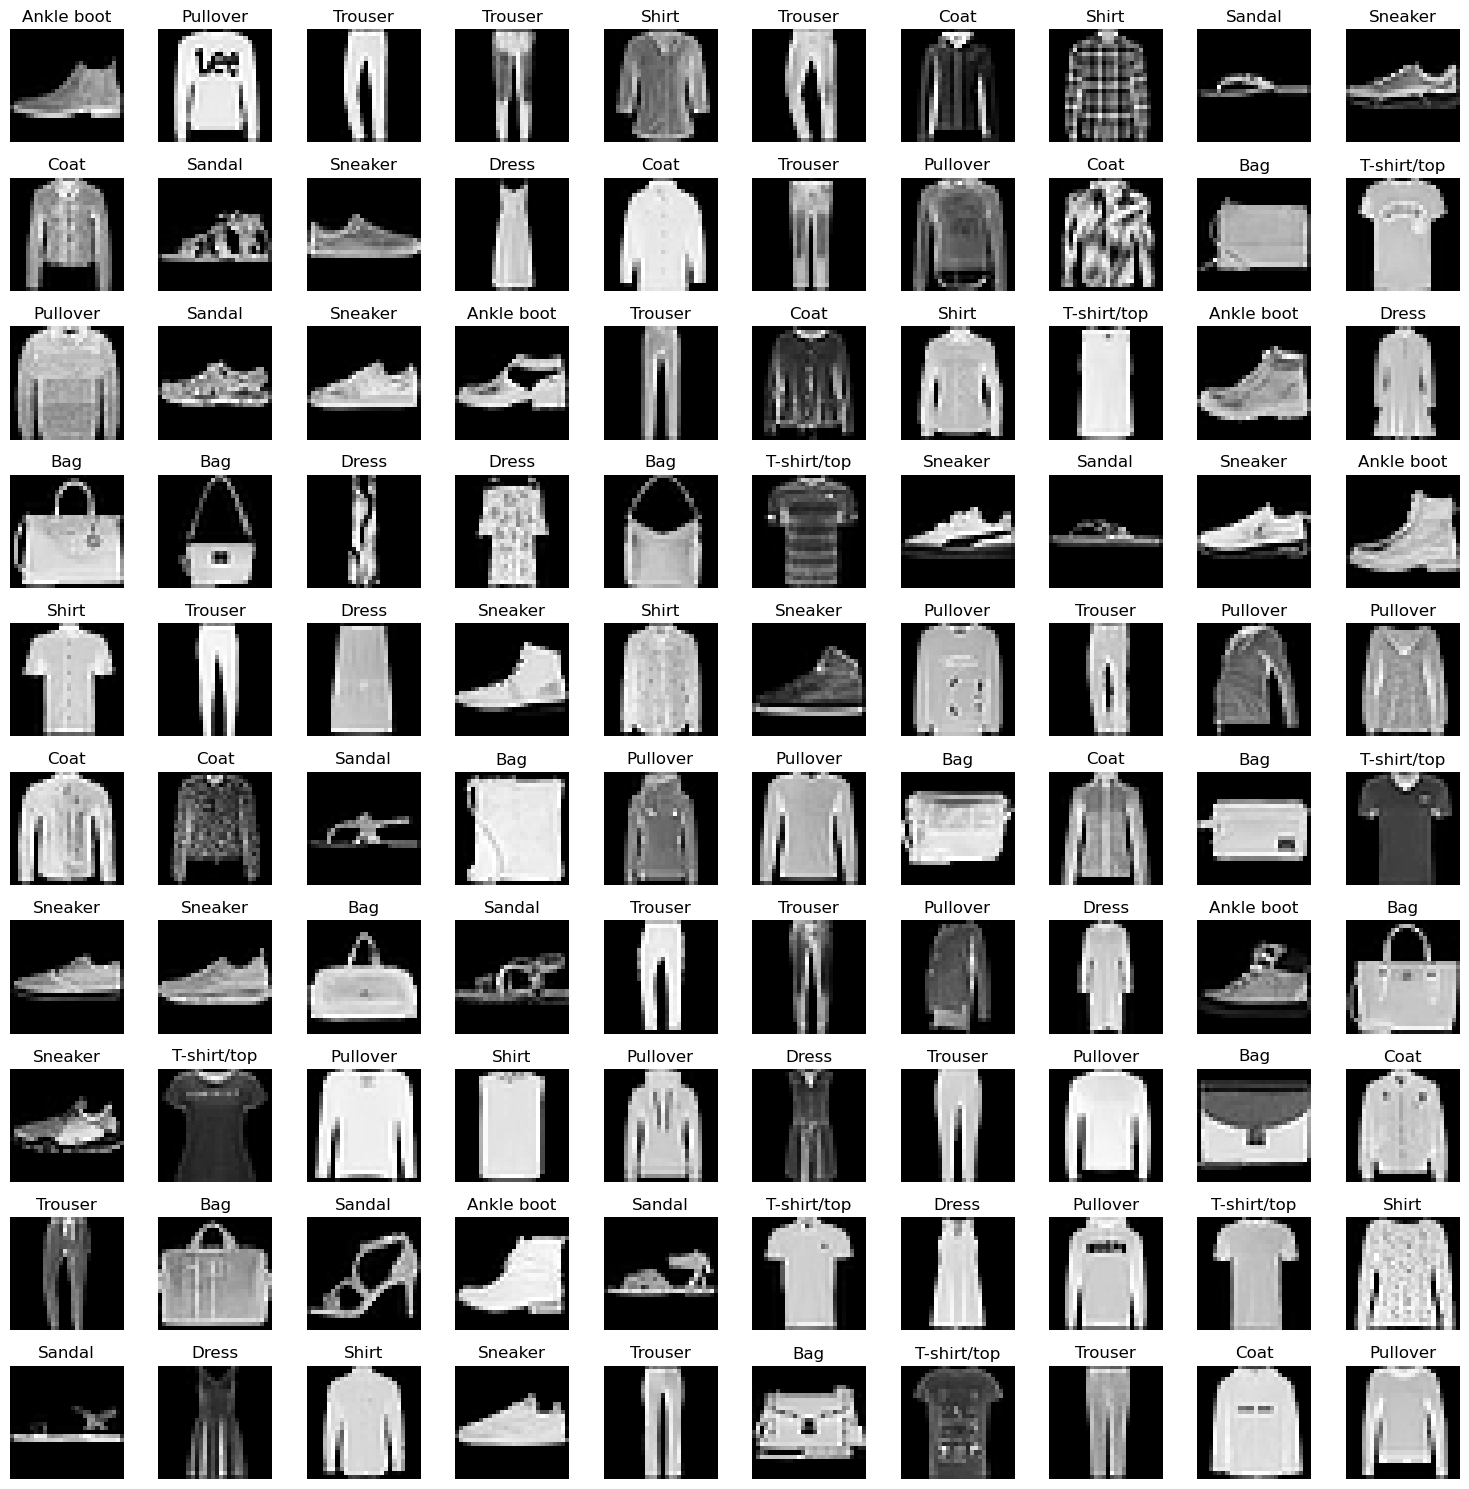

In [ ]:
# visualize 100 samples from the dataset : 
visualize_dataset(test_dataset, 100)

Reconstructed image

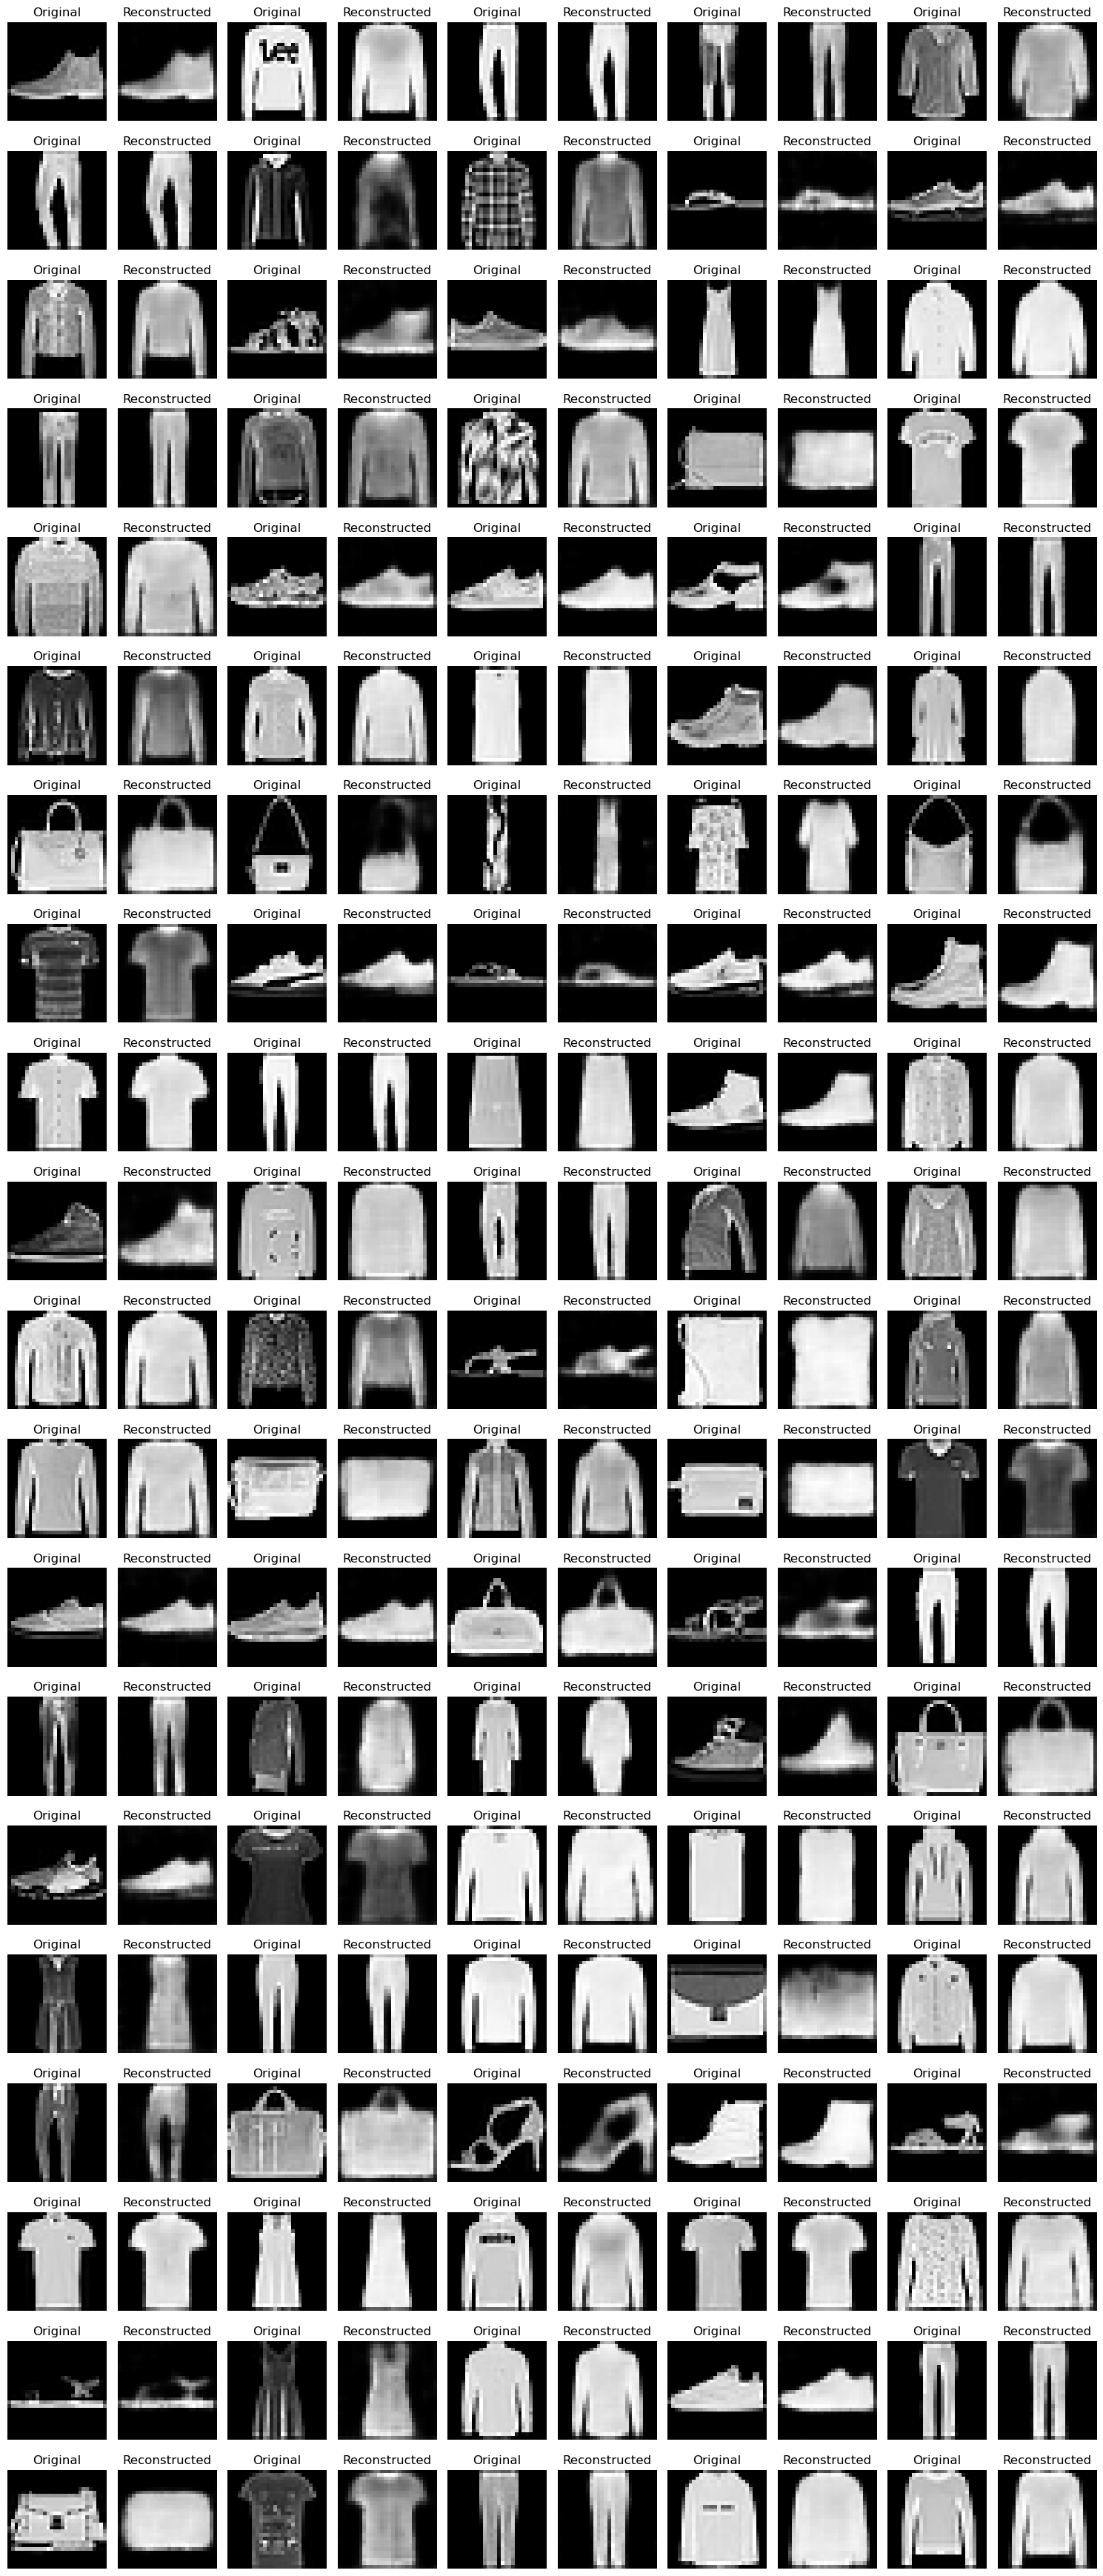

In [ ]:
# visualize 100 samples and reconstructed samples after them : 
def visualize_reconstruction(model, data_loader, device, n_images=10):
    model.eval()
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.to(device)
            recon_x, _, _ = model(x)
            break 
    recon_x = recon_x.clamp(0, 1)

    num = int(np.sqrt(n_images))
    fig, axes = plt.subplots(num*2, num, figsize=(15, 35))
    axes = axes.flatten()
    for i in range(n_images):
        axes[2*i].imshow(x[i].squeeze().cpu().numpy(), cmap='gray')
        axes[2*i].axis('off')
        axes[2*i].set_title("Original")
            
        axes[2*i+1].imshow(recon_x[i].squeeze().cpu().numpy(), cmap='gray')
        axes[2*i+1].axis('off')
        axes[2*i+1].set_title("Reconstructed")
    plt.tight_layout()
    plt.show()

device = 'cuda'
visualize_reconstruction(vae, test_loader, device, 100)

Random sampling from latent variable

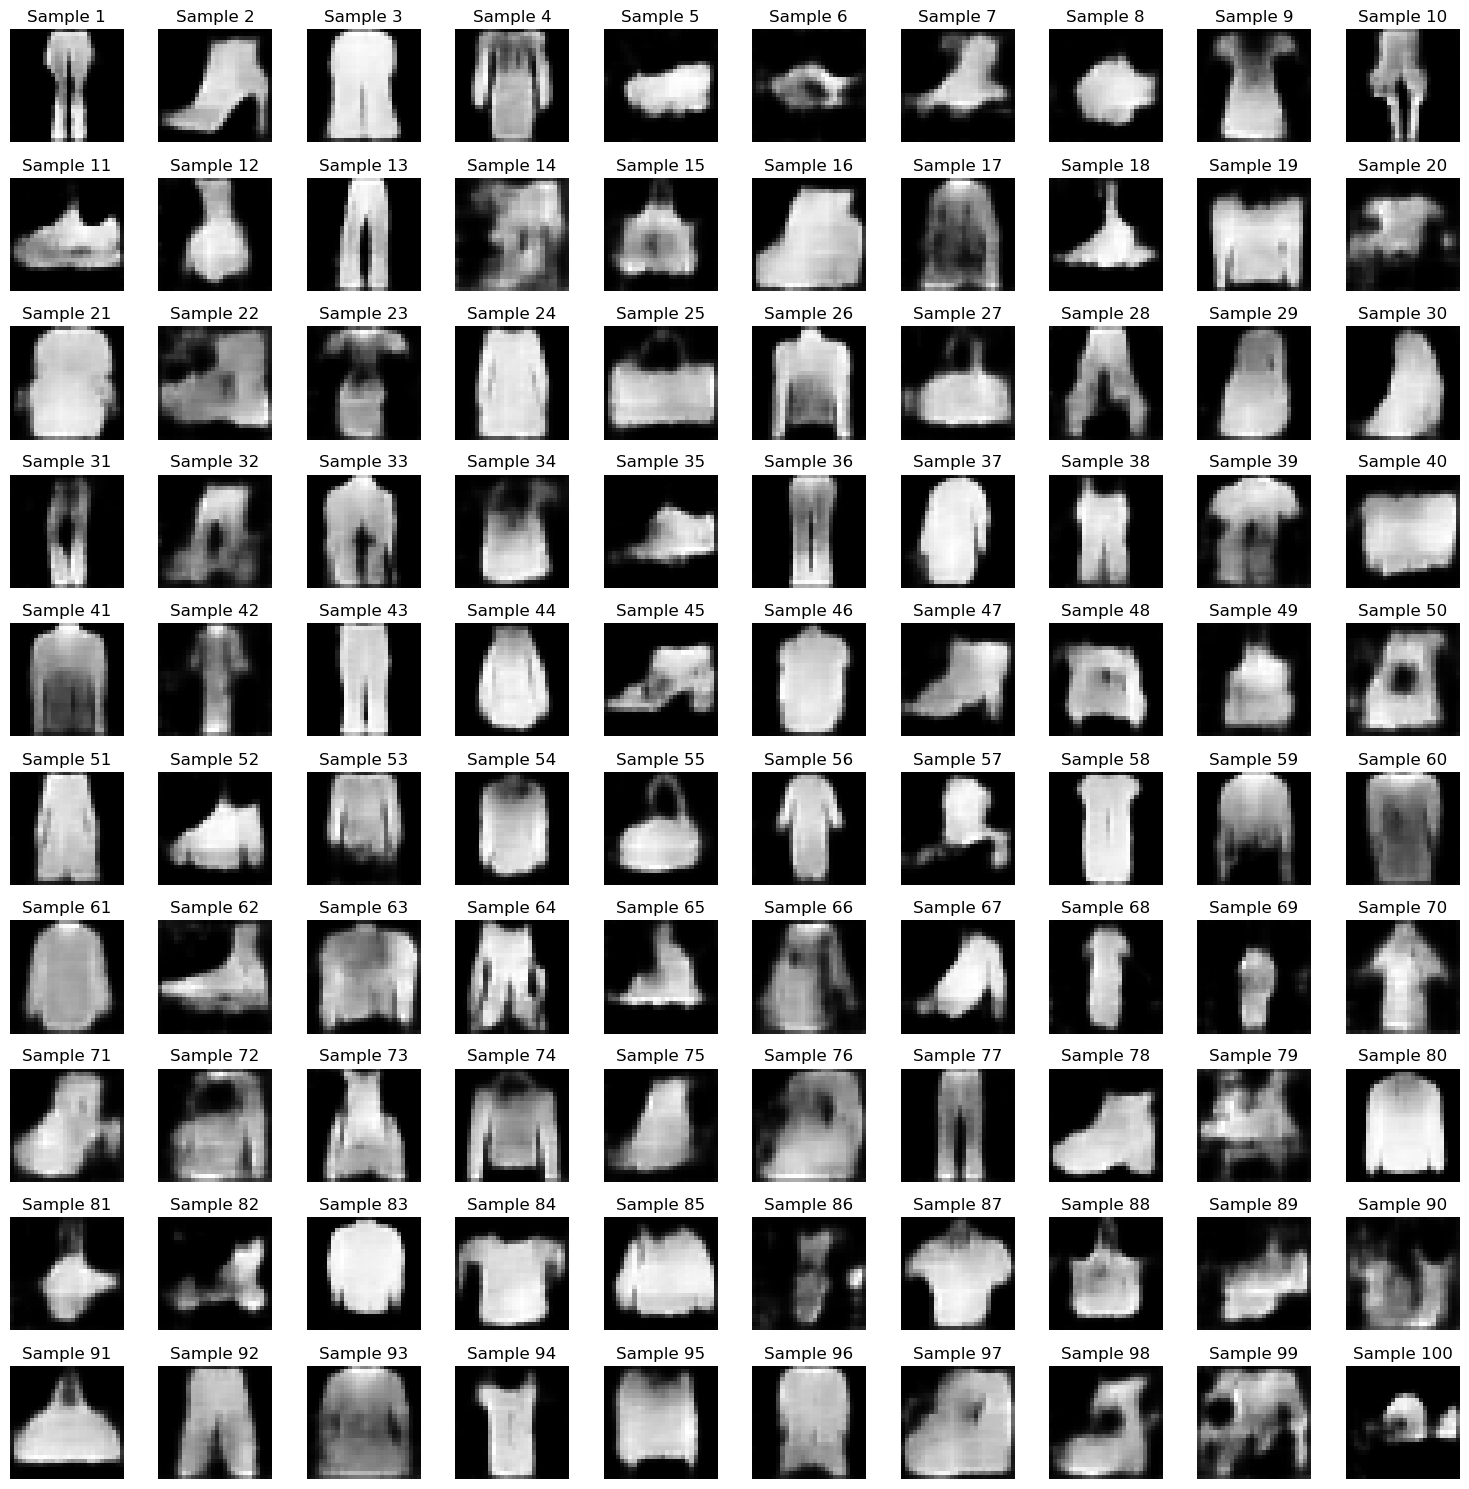

In [ ]:
# visualize 100 random samples from model : 
def visualize_random_samples(model, latent_dim, device, n_samples=100):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim).to(device)
        generated_images = model.decoder(z)
    
    generated_images = generated_images.clamp(0, 1)

    fig, axes = plt.subplots(10, 10, figsize=(15, 15))
    axes = axes.flatten()
    for i in range(n_samples):
        axes[i].imshow(generated_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Sample {i+1}")
    plt.tight_layout()
    plt.show()

visualize_random_samples(vae, 10, Hypers['device'])

In [105]:
import os
import torchvision
from torchvision.utils import save_image
from torch_fidelity import calculate_metrics

# Function to save images to directory
def save_images(images, directory, prefix):
    os.makedirs(directory, exist_ok=True)
    for i, img in enumerate(images):
        save_image(img, os.path.join(directory, f'{prefix}_{i}.png'), normalize=True)

# Function to generate and save reconstructed images
def generate_and_save_reconstructions(model, data_loader, device, directory):
    model.eval()
    reconstructions = []
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.to(device)
            recon_x, _, _ = model(x)
            reconstructions.append(recon_x)
    reconstructions = torch.cat(reconstructions)
    save_images(reconstructions, directory, 'recon')

# Function to generate and save images from random noise
def generate_and_save_random_samples(model, device, latent_dim, num_samples, directory):
    model.eval()
    random_noise = torch.randn(num_samples, latent_dim, device=device)
    with torch.no_grad():
        generated_images = model.decoder(random_noise).view(-1, 1, 28, 28)  # Reshape if necessary
    save_images(generated_images, directory, 'random')

# Function to calculate FID
def calculate_fid(generated_path, real_path):
    return calculate_metrics(input1=generated_path, input2=real_path, cuda=True, fid=True)['frechet_inception_distance']


In [ ]:
# paths to the real, reconstructed, generated images : 
real_images_path = 'real_images'
reconstructed_images_path = 'reconstructed_images'
generated_images_path = 'generated_images'

# save the pictures in the paths : 
generate_and_save_reconstructions(vae, test_loader, Hypers['device'], real_images_path)
generate_and_save_reconstructions(vae, test_loader, Hypers['device'], reconstructed_images_path)
num_samples = len(test_dataset)
generate_and_save_random_samples(vae, Hypers['device'], Hypers['latent_dim'], num_samples, generated_images_path)

# calculate FID between reconstructed and real images : 
fid_recon = calculate_fid(reconstructed_images_path, real_images_path)
print(f'FID Score between test dataset and reconstructed images: {fid_recon}')

# calculate FID between randomly generated and real images : 
fid_generated = calculate_fid(generated_images_path, real_images_path)
print(f'FID Score between test dataset and randomly generated images: {fid_generated}')


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "reconstructed_images" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples                                                            
Extracting statistics from input 2
Looking for samples non-recursivelty in "real_images" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples                                                            
Frechet Inception Distance: 0.5396125545863697
Creating feature extractor "inception-v3-compat" with features ['2048']


FID Score between test dataset and reconstructed images: 0.5396125545863697


Extracting statistics from input 1
Looking for samples non-recursivelty in "generated_images" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples                                                            
Extracting statistics from input 2
Looking for samples non-recursivelty in "real_images" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples                                                            


FID Score between test dataset and randomly generated images: 54.86059951984504


Frechet Inception Distance: 54.86059951984504


<div dir="rtl" style="text-align: right;">
الف و ب پیاده سازی هستند و در بالاتر می توانید آنها را ببینید.
</div>

<div dir="rtl" style="text-align: right;">
ج) 
یک خطای واقعی داریم که خطای 
MSE
است و نشان می دهد که خروجی دیکودر چقدر به داده ی واقعی نزدیک تر است 
<br>
یک خطای 
KLD 
داریم که فاصله ی بین دو توزیع احتمال 
(توزیع نرمال استاندارد و توریعی که انکودر به دست می آید)
را اندازه گیری می کند تا یاد بگیرد داده ها را در فضای کمتری توصیف کند.
<br>
اگر پارامتر بتا را شروع کنیم به بزرگ تر کردن، روی فضای 
latent
بیشتر تاکید می کنیم و می تواند مانع 
overfitting 
شود البته اگر بیش از حد آن را زیاد کنیم باعث می شود که دقت بازسازی مدل کاهش یابد
<br>
اگر هم بیتا را کوچک کنیم تاکید بیشتری روی خطای بازستزی می گذارد که می تواند باعث شود بازسازی بهتر شود اما ممکن است به قیمت باشد که مدل ویژگی های کلی تر را نادیده بگیرد و 
overfitting 
اتفاق بیفتد
.
</div>
<div dir="rtl" style="text-align: right;">
با آزمایش تعداد عدد بزرگتر از 1 برای پارامتر بتا و هایپر پارامتر های مختلف 
بهترین هایپر پارامتر هایی که پیدا کردم 
همان هایی هستند که در بالا تر به آن اشاره شده است.
در این هایپر پارامتر ها 
پارامتر بتا 
2
است.

</div>

<div dir="rtl" style="text-align: right;">
د)
نمونه‌های بازسازی شده معمولاً جزئیات کمتری نسبت به تصاویر اصلی دارند و ممکن است برخی ویژگی‌های ریز مانند بافت‌ها یا خطوط دقیق کمتر دیده شوند. این به دلیل محدودیت‌های فضای 
latent
 و خطای بازسازی است.

نمونه‌های تولید شده از نویز تصادفی ممکن است بسیار متفاوت‌تر از تصاویر واقعی به نظر برسند. این تصاویر می‌توانند شامل ویژگی‌های غیر واقعی باشند و گاهی اوقات کاملاً انتزاعی به نظر می‌رسند. این تفاوت به دلیل عدم وجود مرجع واقعی در هنگام تولید است.
</div>

<div dir="rtl" style="text-align: right;">
ر)
معیار 
FID
از دو مرحله ی اصلی تشکیل شده است :
1.
استخراج ویژگی ها :
ابتدا ویژگی های تصاویر توسط یک شبکه ی از پیش آموزش داده شده مانند 
Inception v3
استخراج می شوند. این شبکه برای هر تصویر، یک بردار ویژگی در فضای ویژگی تعریف شده
توسط لایه های داخلی شبکه ی 
inception
ایجاد می کند.

2.
مقایسه توزیع ها :
بردارهای ویژگی تصاویر واقعی و تصاویر تولیدی به دست آمده از مدل به کار رفته جمع‌آوری شده و توزیع آماری آن‌ها محاسبه می‌شود. سپس، فاصله فرشه بین دو توزیع ویژگی (که به طور معمول با استفاده از میانگین و کوواریانس بردارهای ویژگی تعیین می‌شود) محاسبه می‌شود. این فاصله نشان‌دهنده تفاوت آماری بین دو گروه تصویر است.

فرمول آن عبارت است از :
</div>

$$FID = |\mu_1 - \mu_2| + Tr(\sigma_1 + \sigma_2 - 2 \sqrt{\sigma_1 * \sigma_2})$$

<div dir="rtl" style="text-align: right;">
معیار FID اطلاعات مهمی در مورد کیفیت تصاویر تولید شده توسط مدل‌هایی مانند VAE ارائه می‌دهد:


1.تنوع: FID به خوبی توانایی مدل در تولید تصاویر متنوع را ارزیابی می‌کند. اگر تصاویر تولیدی دارای تنوع کمی باشند و شبیه به هم باشند، مقدار FID بالا خواهد رفت زیرا توزیع ویژگی‌های تصاویر تولیدی تفاوت زیادی با توزیع تصاویر واقعی خواهد داشت.

2.واقع‌گرایی: FID همچنین کیفیت و واقع‌گرایی تصاویر تولیدی را ارزیابی می‌کند. یک مقدار پایین FID نشان‌دهنده آن است که تصاویر تولیدی در سطح ویژگی‌های دیداری نزدیک به تصاویر واقعی هستند.



</div>

<div dir="rtl" style="text-align: right;">
ه)
همانطور که از خروجی های چاپ شده ی بالا پیدا است، 
FID
در داده های 
reconstructed
کمتر از داده های 
random generated
است و علتش هم واضح است که زیرا که در اولی دیتایی دارد که از روی آن
بازسازی کند ولی در دومی دیتای رندومی با دیکودر داده شده است و 
با استفاده از ان سمپل تولید شده است.
</div>

<div dir="rtl" style="text-align: right;">
برای مدل های 
vae 
علاوه بر معیار 
FID
معیار های دیگری نیز وجود دارند 
که می توانند به ارزیابی و کارایی این مدل ها در بازسازی و تولید داده های جدید کمک کنند.
<br>
معیار 
inception score
با استفاده از مدل 
inception
که برای تخمین توزیع کلاس های تصاویر تولید شده استفاده می شود، کیفیت و تنوع 
تصاویر تولیدی را ارزیابی می کند.
این 
score
از دو جزء تنوع تصاویر و وضوح آنها برای پیش بینی درست کلاس تصویر تشکیل شده است.
این معیار می‌تواند به خوبی تنوع تصاویر تولیدی را ارزیابی کند اما ممکن است در ارزیابی دقیق واقع‌گرایی تصاویر کوتاهی کند.

<br>
2.
معیار
Perceptual Path Length - PPL
میزان تغییرات معنی‌دار در فضای تصاویر تولیدی را هنگام جابجایی خطی در فضای
latent
 اندازه‌گیری می‌کند. این معیار برای ارزیابی پیوستگی و یکنواختی فضای
latent
  به کار می‌رود، که می‌تواند در درک بهتر توزیع فضای ویژگی‌های تصاویر تولیدی کمک کند.


<br>
3.
معیار 
Precision and Recall for Distributions - PRD
برای مقایسه توزیع‌های تصاویر واقعی و تصاویر تولیدی استفاده می‌شود. دقت (precision) نشان‌دهنده کیفیت تصاویر تولیدی است، در حالی که بازخوانی (recall) نشان‌دهنده تنوع تصاویر تولیدی است. این معیارها به خوبی می‌توانند کیفیت و تنوع تصاویر تولیدی را در مقایسه با دیتاست واقعی ارزیابی کنند.


<br>

مقایسه با 
FID
<br>
تنوع vs واقع‌گرایی: FID به طور مستقیم واقع‌گرایی تصاویر تولیدی را با توجه به تصاویر واقعی اندازه‌گیری می‌کند و به خوبی تنوع را در نظر می‌گیرد. در حالی که IS بیشتر بر تنوع تمرکز دارد و ممکن است در ارزیابی واقع‌گرایی دقیق کوتاهی کند.
<br>
کاربرد در تحلیل فضای
latent 
:
PPL, PRD
اطلاعات بیشتری در مورد رفتار فضای
latent 
و تناسب 
آن با داده‌های واقعی ارائه می‌دهند، که می‌تواند برای درک بهتر دینامیک‌های مدل و بهبود ساختارهای
latent
مفید باشد.

<br>
در کل هر معیاری نقاط ضعف و قوت خود را دارد و بسته به هدفی که مد نظر داریم هر کدام را استفاده می کنیم.
</div>
